## Metro line 1 clustering
Objective : What are the best locations on metro ligne 1 in Paris for someone who works in La Défense business district and wants restaurants and cinemas close to home ? 
We will segment the metro stations of the line 1 with 3 variables: (a) transport time, (b) and (c) numbers of restaurants and  cinemas around the studied station.
N.B. In this project, we will use the Foursquare API.

In [1]:
import pandas as pd
import numpy as np
import requests
!conda install -c conda-forge folium=0.5.0 --yes 
print("ok")

Solving environment: ...working... done

# All requested packages already installed.

ok


In [2]:
import folium
from geopy.geocoders import Nominatim

In [3]:
CLIENT_ID = '' # my Foursquare ID
CLIENT_SECRET = '' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('my credentials ok')

my credentials ok


### 1. Data
We download the data related to the metro stations on the ratp website:
https://dataratp2.opendatasoft.com/explore/dataset/positions-geographiques-des-stations-du-reseau-ratp/export/?disjunctive.stop_name&location=9,48.86463,2.39738
(Licence ODbL Version Française)

In [4]:
# We import data on stations subway in Paris.
data=pd.read_csv("metro_idf.csv", sep=";")
data.head(2)

,Geo Point,Geo Shape,OBJECTID,id_ref_zdl,gares_id,nom_gare,nomlong,nom_iv,num_mod,mode_,...,reseau,res_com,cod_resf,res_stif,exploitant,num_psr,idf,principal,x,y
0,"48.8794817719,2.38911580738","{""type"": ""Point"", ""coordinates"": [2.3891158073...",3,42369,93,Botzaris,BOTZARIS,Botzaris,2362,Metro,...,METRO,M7bis,3.0,110.0,RATP,0,1,0,655197.2716,6.864558e+06
1,"48.8607869635,2.32099819195","{""type"": ""Point"", ""coordinates"": [2.3209981919...",27,45704,30,Assemblée Nationale,ASSEMBLEE NATIONALE,Assemblée Nationale,2312,Metro,...,METRO,M12,3.0,110.0,RATP,0,1,0,650183.7135,6.862520e+06


In [5]:
# We select the columns we need: all the stations located in the line 1 and their geographical coordinates.
metro=data[["Geo Point","nomlong","ligne"]]
ligne1=metro[metro["ligne"]=="1"]

In [6]:
ligne1.head()

,Geo Point,nomlong,ligne
3,"48.8524794228,2.36932058493",BASTILLE,1
12,"48.8751498197,2.29590490608",CHARLES DE GAULLE ETOILE,1
17,"48.8698082202,2.30747079345",FRANKLIN-D.ROOSEVELT,1
20,"48.8574779825,2.35157756299",HOTEL DE VILLE,1
21,"48.8886312178,2.24793243532",ESPLANADE DE LA DEFENSE,1


In [7]:
print("There are {} stations on ligne 1.".format(len(ligne1)))

There are 25 stations on ligne 1.


In [8]:
# We split up the Geo Point column into 2 columns Latitude and Longitude.
ligne1["Latitude"]=pd.to_numeric(ligne1["Geo Point"].str.split(",").str.get(0))
ligne1["Longitude"]=pd.to_numeric(ligne1["Geo Point"].str.split(",").str.get(1))

C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Claire\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# We put into order the stations from West to East. La Défense station is the western station of the line.
ligne1_WE=ligne1.sort_values(by="Latitude", ascending=False).reset_index(drop = True)
# We add a column "transport time", that is proportional to the distance between La Défense station and each station of the line.
ligne1_WE["Transport time"]=ligne1_WE.index

In [10]:
# We delete "Geo Point" and "Ligne" columns, we rename "nomlong" as "station".
ligne1_WE.drop(columns=["Geo Point", "ligne"], inplace=True)
ligne1_WE.rename(columns={"nomlong":"Station"}, inplace=True)

In [11]:
ligne1_WE.head()

,Station,Latitude,Longitude,Transport time
0,LA DEFENSE-GRANDE ARCHE,48.892187,2.237018,0
1,ESPLANADE DE LA DEFENSE,48.888631,2.247932,1
2,PONT DE NEUILLY (AVENUE DE MADRID),48.884708,2.260515,2
3,LES SABLONS (JARDIN D'ACCLIMATATION),48.881192,2.271687,3
4,PORTE MAILLOT,48.877551,2.283162,4


In [12]:
ligne1_WE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 4 columns):
Station           25 non-null object
Latitude          25 non-null float64
Longitude         25 non-null float64
Transport time    25 non-null int64
dtypes: float64(2), int64(1), object(1)
memory usage: 880.0+ bytes


### Surroundings of each metro station
We use Foursquare application in order to retrieve data about restautants and cinemas located near each station.

In [13]:
address = 'Paris, France'
geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Paris are {}, {}.'.format(latitude, longitude))

The geographical coordinates of Paris are 48.8566101, 2.3514992.


In [14]:
# We create a map to visualize the location of the metro stations.
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)
for lat, lng, nm in zip(ligne1_WE['Latitude'], ligne1_WE['Longitude'], ligne1_WE["Station"]):
    label = '{}'.format(nm)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
       [lat, lng],
       radius=5,
       popup=label,
       fill=True,
       color='blue',
       fill_color='blue',
       fill_opacity=0.7,
       parse_html=False).add_to(map_paris)
map_paris

In [15]:
# We define the categories we are looking for in a radius of 300 m around the station and we limit the result to 50 venues.
list_categories=["Restaurant","Cinema"]
radius=300
LIMIT=50

In [16]:
# We define a function that counts the number of venues (restaurant and cinema) for each station.
def searchVenues(row):
    lati=ligne1_WE.loc[row,"Latitude"]
    longi=ligne1_WE.loc[row,"Longitude"]
    total_cat=[]
    for category in list_categories:
        search_query=[category]
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lati, longi, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        # assign relevant part of JSON to venues
        venues = results['response']['venues']
        # Number of venues for a category
        total_cat.append(len(venues))
    return total_cat

In [17]:
# We build a dataframe that contains the number of restaurants and the number of cinemas for all the stations.
stations=[]
for row in range(len(ligne1_WE)):
    stations.append(searchVenues(row))
resultat=pd.DataFrame(stations,columns=[cat for cat in list_categories])

In [18]:
# We add the result to the dataframe ligne1_WE.
res=pd.concat([ligne1_WE, resultat], axis=1)
res.head()

,Station,Latitude,Longitude,Transport time,Restaurant,Cinema
0,LA DEFENSE-GRANDE ARCHE,48.892187,2.237018,0,7,1
1,ESPLANADE DE LA DEFENSE,48.888631,2.247932,1,10,0
2,PONT DE NEUILLY (AVENUE DE MADRID),48.884708,2.260515,2,1,0
3,LES SABLONS (JARDIN D'ACCLIMATATION),48.881192,2.271687,3,1,0
4,PORTE MAILLOT,48.877551,2.283162,4,8,1


### Clustering
Now the data set is prepared, we can proceed to the clustering.

In [19]:
# We define our variable.
X=res[["Transport time","Restaurant","Cinema"]]

In [20]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [21]:
# we normalize the dataset.
X = preprocessing.StandardScaler().fit(X).transform(X)

Text(0, 0.5, 'inertia')

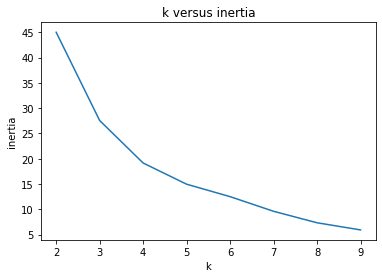

In [22]:
# Before applying the K-Means algorithm, we determine the best number of clusters k by minimizing the inertia.
inertie=[]
for k in range(2,10):
    model=KMeans(n_clusters=k)
    model.fit(X)
    inertie.append(model.inertia_)
plt.plot(range(2,10), inertie)
plt.title("k versus inertia")
plt.xlabel("k")
plt.ylabel("inertia")

In [23]:
# We choose k=5 and we fit the K-Means model with our data X.
model=KMeans(n_clusters=5)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [24]:
# We attribute the predicted cluster to each station and add it in the dataframe.
clusters=model.labels_
res["Cluster"]=clusters
res.head()

,Station,Latitude,Longitude,Transport time,Restaurant,Cinema,Cluster
0,LA DEFENSE-GRANDE ARCHE,48.892187,2.237018,0,7,1,1
1,ESPLANADE DE LA DEFENSE,48.888631,2.247932,1,10,0,1
2,PONT DE NEUILLY (AVENUE DE MADRID),48.884708,2.260515,2,1,0,1
3,LES SABLONS (JARDIN D'ACCLIMATATION),48.881192,2.271687,3,1,0,1
4,PORTE MAILLOT,48.877551,2.283162,4,8,1,1


### Results
We have segmented the 25 stations of the metro line 1 in 5 clusters by applying the K-Means algorithm. We now study the characteristics of each group.

In [25]:
# We observe the resulting centroides of the 5 clusters.
centroides=pd.DataFrame(model.cluster_centers_, columns=["Transport time","Restaurant","Cinema"])
centroides["Number of stations"]=res["Cluster"].value_counts()
centroides["Ratio"]=centroides[["Restaurant","Cinema"]].mean(axis=1)/centroides["Transport time"]
centroides

,Transport time,Restaurant,Cinema,Number of stations,Ratio
0,0.776580,0.053275,-0.625119,5,-0.368181
1,-1.168833,-0.416052,-0.439071,7,0.365802
2,1.386750,-1.422885,-0.625119,4,-0.738418
3,-0.485363,1.185368,1.979543,4,-3.260356
4,0.138675,0.719212,0.156280,5,3.156630


In [26]:
# Cluster 0: high transport time, some restaurants
res[res["Cluster"]==0]

,Station,Latitude,Longitude,Transport time,Restaurant,Cinema,Cluster
12,PALAIS ROYAL-MUSEE DU LOUVRE,48.862348,2.336496,12,8,0,0
17,BASTILLE,48.852479,2.369321,17,7,0,0
18,NATION,48.847579,2.395555,18,6,0,0
19,REUILLY-DIDEROT,48.847304,2.386342,19,7,0,0
22,GARE DE LYON,48.846028,2.374963,22,9,0,0


In [27]:
# Cluster 1: low transport time, some restaurants, few or none cinemas
res[res["Cluster"]==1]

,Station,Latitude,Longitude,Transport time,Restaurant,Cinema,Cluster
0,LA DEFENSE-GRANDE ARCHE,48.892187,2.237018,0,7,1,1
1,ESPLANADE DE LA DEFENSE,48.888631,2.247932,1,10,0,1
2,PONT DE NEUILLY (AVENUE DE MADRID),48.884708,2.260515,2,1,0,1
3,LES SABLONS (JARDIN D'ACCLIMATATION),48.881192,2.271687,3,1,0,1
4,PORTE MAILLOT,48.877551,2.283162,4,8,1,1
5,ARGENTINE,48.875594,2.289323,5,5,0,1
10,CONCORDE,48.866286,2.322943,10,5,0,1


In [28]:
# Cluster 2: high transport time, few or none venues
res[res["Cluster"]==2]

,Station,Latitude,Longitude,Transport time,Restaurant,Cinema,Cluster
20,PORTE DE VINCENNES,48.847158,2.410140,20,0,0,2
21,SAINT-MANDE,48.846357,2.419480,21,0,0,2
23,BERAULT,48.845471,2.429205,23,2,0,2
24,CHATEAU DE VINCENNES,48.844456,2.440440,24,1,0,2


In [29]:
# Cluster 3: low transport time, many venues
res[res["Cluster"]==3]

,Station,Latitude,Longitude,Transport time,Restaurant,Cinema,Cluster
6,CHARLES DE GAULLE ETOILE,48.875150,2.295905,6,10,3,3
7,GEORGE V,48.872024,2.300560,7,13,6,3
8,FRANKLIN-D.ROOSEVELT,48.869808,2.307471,8,13,3,3
13,LOUVRE-RIVOLI,48.860806,2.341109,13,14,4,3


In [30]:
# Cluster 4: medium transport time, many restaurants, some cinemas
res[res["Cluster"]==4]

,Station,Latitude,Longitude,Transport time,Restaurant,Cinema,Cluster
9,CHAMPS-ELYSEES-CLEMENCEAU,48.867905,2.313546,9,9,1,4
11,TUILERIES,48.864344,2.330130,11,16,0,4
14,CHATELET,48.858799,2.347306,14,10,1,4
15,HOTEL DE VILLE,48.857478,2.351578,15,12,2,4
16,SAINT-PAUL (LE MARAIS),48.855236,2.360956,16,5,2,4


In [31]:
# Overview: median of categories for each cluster and ratio=nb of venues/transport time
res["Venues"]=res["Restaurant"]+res["Cinema"]
synt=res[["Cluster","Transport time", "Venues", "Restaurant", "Cinema"]]
synt=synt.groupby("Cluster").median()
synt["Ratio"]=synt["Venues"]/synt["Transport time"]
synt

,Transport time,Venues,Restaurant,Cinema,Ratio
Cluster,,,,,
0,18.0,7.0,7.0,0.0,0.388889
1,3.0,5.0,5.0,0.0,1.666667
2,22.0,0.5,0.5,0.0,0.022727
3,7.5,17.0,13.0,3.5,2.266667
4,14.0,11.0,10.0,1.0,0.785714


Text(4.4, 18, 'High')

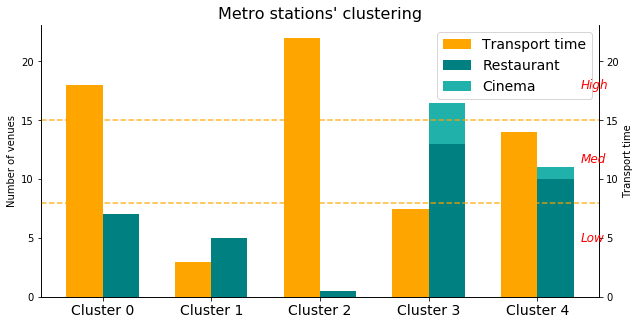

In [32]:
# We build a bar plot to visualize the differences and relative proportions of the 5 clusters.
fig, ax = plt.subplots(figsize=(10,5))
width=1
x=np.arange(5)
ax1=ax.bar(x-width/6,synt["Transport time"],width/3, color="orange",label="Transport time")
ax2=ax.bar(x+width/6,synt["Restaurant"],width/3,color="teal",label="Restaurant")
ax3=ax.bar(x+width/6, synt["Cinema"], width/3, bottom=synt["Restaurant"],color="lightseagreen",label="Cinema")
ax.set_title("Metro stations' clustering", fontsize=16)
ax.legend(fontsize=14)

xlabel=["Cluster {}".format(i) for i in range(5)]
ax.set_xticks(x)
ax.set_xticklabels(xlabel, fontsize=14)

ax.set_ylabel("Number of venues")
ax1=ax.twinx()
ax1.set_ylim(ax.get_ylim())
ax1.set_ylabel("Transport time")
ax1.axhline(8, color='orange', linestyle='--', alpha=0.8)
ax1.axhline(15, color="orange", linestyle='--', alpha=0.8)

for pos in ["top"]:
    ax.spines[pos].set_visible(False)
    ax1.spines[pos].set_visible(False)
    
plt.text(4.4, 5, "Low", style = 'italic', fontsize = 12, color="red",rotation=0, ha ="left", va = "center")
plt.text(4.4, 11.7, "Med", style = 'italic', fontsize = 12, color="red",rotation=0, ha ="left", va = "center")
plt.text(4.4, 18, "High", style = 'italic', fontsize = 12, color="red",rotation=0, ha ="left", va = "center")

We can resume the attributes of the clusters in the table below:

Cluster|Transport time|Venues
:-----:|:------------:|:----:
0|high|medium
1|low|medium
2|high|very few
3|low|high
4|medium|high

### Visualization: map of clustered stations

In [36]:
# We match each cluster with a color.
cluster_list=list(range(5))
color_list=["darkcyan","purple","navy","orangered","green"]
colors={key: col for key, col in zip(cluster_list,color_list)}
print(colors)

{0: 'darkcyan', 1: 'purple', 2: 'navy', 3: 'orangered', 4: 'green'}


In [37]:
from folium.features import DivIcon

In [38]:
# We create a map of Paris using latitude and longitude values and we represent each cluster with the corresponding color.
map_paris = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, name, clust, rest, cin in zip(res["Latitude"], res["Longitude"], res["Station"], res["Cluster"],
                                            res["Restaurant"],res["Cinema"]):
    label = "{} : cluster {}".format(name, clust)
    label = folium.Popup(label, parse_html=True)
    col=colors[clust]
    folium.CircleMarker(
       [lat, lng],
       radius=(rest+cin)*0.6+2,
       legend_name="CLusters",
       popup=label,
       fill=True,
       color=col,
       fill_color=col,
       fill_opacity=0.7,
       parse_html=False).add_to(map_paris)  

folium.Circle(
    radius=500,
    location=[48.892187,2.237018],
    color="red",
    fill=False).add_to(map_paris)

folium.Marker([48.886,2.194], icon=DivIcon(
        icon_size=(150,50),
        icon_anchor=(7,20),
        html='<div style="font-size: 14pt; color : red">LA DEFENSE</div>')).add_to(map_paris)

map_paris